### Restaurant Reviews for Zomato Dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from folium.plugins import HeatMap
import folium
from tqdm import tqdm
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.colors as mcolors
from sklearn.manifold import TSNE
from gensim.models import word2vec
import nltk

unable to import 'smart_open.gcs', disabling that module


In [2]:
# Loading the dataset
zomato = pd.read_csv('zomato.csv')

In [3]:
# Exploring the dataset
display(zomato.head())

# Shape of the dataset
zomato.shape

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


(51717, 17)

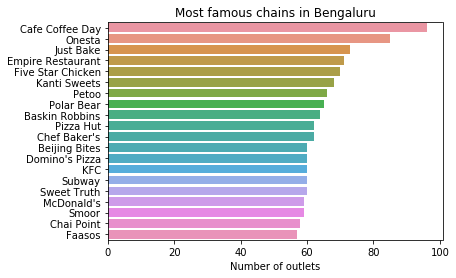

In [4]:
# Plotting top chains in bengaluru
%matplotlib inline
bestRest = zomato['name'].value_counts()[:20]
sns.barplot(x=bestRest.values, y=bestRest.index)
plt.title('Most famous chains in Bengaluru')
plt.xlabel('Number of outlets')
plt.show()

In [5]:
len(zomato['rest_type'].value_counts())

93

In [6]:
"Not surprisingly most famous chain is Cafe Coffee Day, with Onesta and Just Bake coming in second. Surprisingly fast\
food chains such as Pizza hut and Dominos are way behind"

'Not surprisingly most famous chain is Cafe Coffee Day, with Onesta and Just Bake coming in second. Surprisingly fastfood chains such as Pizza hut and Dominos are way behind'

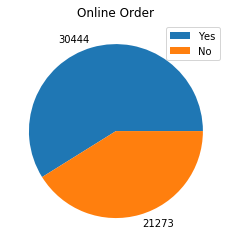

In [7]:
# How many accept or not accept online orders
OnlineOrd = zomato['online_order'].value_counts()
labels = ['Yes', 'No']
plt.pie(OnlineOrd, labels = OnlineOrd)
plt.legend(labels)
plt.title('Online Order')
plt.show()

In [8]:
"As clearly indicated,almost 60 per cent of restaurants in Banglore accepts online orders.\
Nearly 40 per cent of the restaurants do not accept online orders.\
This might be because of the fact that these restaurants cannot afford to pay commission to zomoto for giving them orders online. zomato may want to consider giving them some more benefits if they want to increse the number of restaurants serving their customers online."

'As clearly indicated,almost 60 per cent of restaurants in Banglore accepts online orders.Nearly 40 per cent of the restaurants do not accept online orders.This might be because of the fact that these restaurants cannot afford to pay commission to zomoto for giving them orders online. zomato may want to consider giving them some more benefits if they want to increse the number of restaurants serving their customers online.'

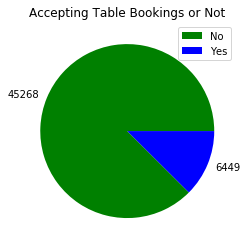

In [9]:
# How many accpet tables booking
BookOrd = zomato['book_table'].value_counts()
labels = ['No', 'Yes']
plt.pie(BookOrd, labels = BookOrd, colors = ['green', 'blue'])
plt.legend(labels)
plt.title('Accepting Table Bookings or Not')
plt.show()

In [10]:
#Almost 90 percent of restaurants in Banglore do not provide table booking facility.
#In India you cannot find table booking facility in any average restaurants,usually only five star restaurants 
#provides table booking.

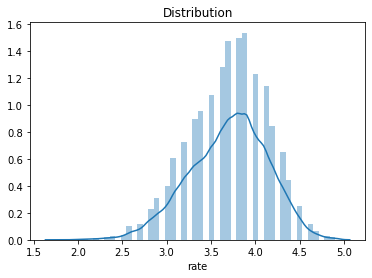

In [11]:
# Looking at the distribution of the ratings
ratings = zomato['rate'].dropna()
# Preparing the data for visualization
ratings=ratings.apply(lambda x: float(x.split('/')[0]) if len(x)>3 else np.nan).dropna()
#Making a distplot
sns.distplot(ratings)
plt.title('Distribution')
plt.show()

In [12]:
#Almost more than 50 percent of restaurants has rating between 3 and 4. Restaurants having rating more than 
#4.5 are very rare.

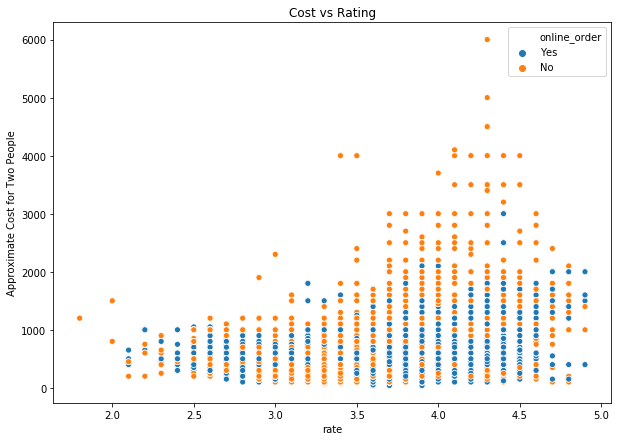

In [13]:
# Making a cost vs rating scatterplot
plt.figure(figsize=(10,7))
# Cleaning data for scatterplot
cost = zomato['approx_cost(for two people)'].dropna()
cost = cost.apply(lambda x: int(x.replace(',','')))
# Making a scatterplot
sns.scatterplot(ratings, cost, hue = zomato['online_order'])
plt.title('Cost vs Rating')
plt.ylabel('Approximate Cost for Two People')
plt.show()

In [14]:
# Almost 90 percent of food vendors sell food for less than 2000 Rs.

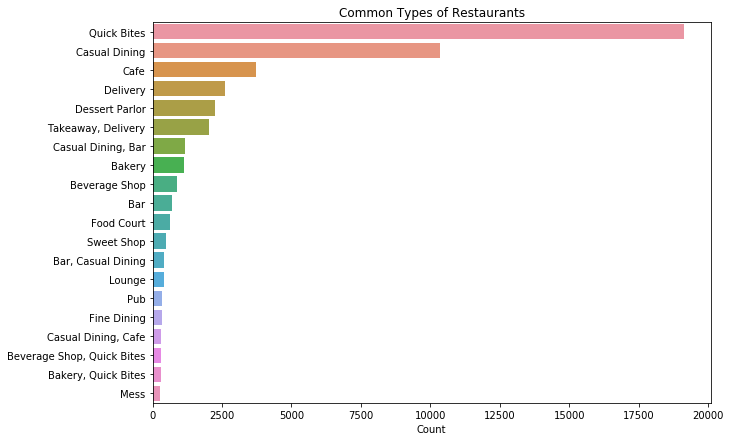

In [15]:
# Most Common Types of Restaurant
plt.figure(figsize=(10,7))
RestType = zomato['rest_type'].value_counts()[:20]
sns.barplot(RestType.values, RestType.index)
plt.title('Common Types of Restaurants')
plt.xlabel('Count')
plt.show()

In [16]:
# No surprise that quick bites dominates as Banglore being IT capital of India, people prefer Quick Bites.
# Surprised to see that Mess is at the lowest.

In [17]:

"""
locations=pd.DataFrame({"Name":zomato['location'].unique()})
locations['Name']=locations['Name'].apply(lambda x: "Bangalore " + str(x))
lat_lon=[]
geolocator=Nominatim(user_agent="app", timeout=10)
for location in locations['Name']:
    location = geolocator.geocode(location)
    if location is None:
        lat_lon.append(np.nan)
    else:    
        geo=(location.latitude,location.longitude)
        lat_lon.append(geo)


locations['geo_loc']=lat_lon
locations.to_csv('locations.csv',index=False)
"""

'\nlocations=pd.DataFrame({"Name":zomato[\'location\'].unique()})\nlocations[\'Name\']=locations[\'Name\'].apply(lambda x: "Bangalore " + str(x))\nlat_lon=[]\ngeolocator=Nominatim(user_agent="app", timeout=10)\nfor location in locations[\'Name\']:\n    location = geolocator.geocode(location)\n    if location is None:\n        lat_lon.append(np.nan)\n    else:    \n        geo=(location.latitude,location.longitude)\n        lat_lon.append(geo)\n\n\nlocations[\'geo_loc\']=lat_lon\nlocations.to_csv(\'locations.csv\',index=False)\n'

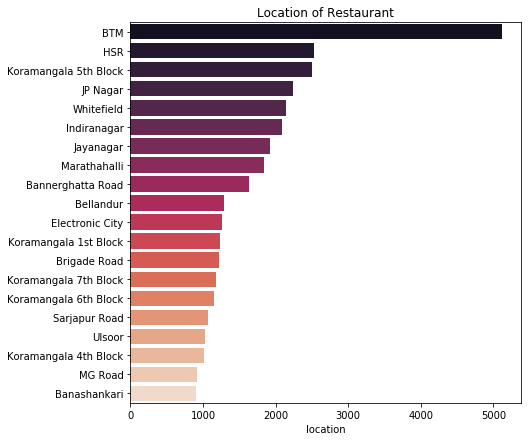

In [18]:
# Loading Locations csv
locations = pd.read_csv('locations.csv')
plt.figure(figsize=(7,7))
Rest_locations=zomato['location'].value_counts()[:20]
sns.barplot(Rest_locations,Rest_locations.index,palette="rocket")
plt.title('Location of Restaurant')
plt.show()

In [19]:
# Making word cloud for every dished liked
# Preparing the dataset for word cloud by getting different dishes using split.
zomato['dish_liked1'] = zomato['dish_liked'].apply(lambda x: x.split(',') if type(x)==str else [''])



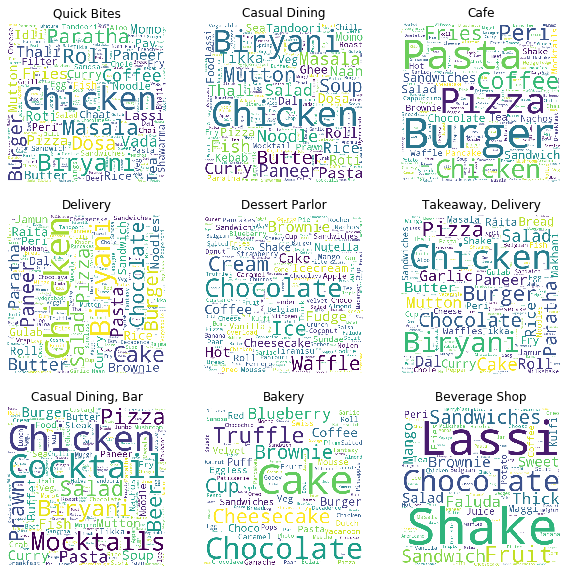

In [20]:
# Getting most common dishes for each type of restaurant
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
# Getting different restaurant type
restType = zomato['rest_type'].value_counts()[:9]

for rest, subplot in zip(restType.index, ax.flatten()):
    
    # Getting the dishes for different restaurant types
    corpus = zomato[zomato['rest_type']==rest]['dish_liked1'].values.tolist()
    
    # Getting All the dishes
    corpus = ','.join(x for words in corpus for x in words)
    
    # Generating Word Cloud
    wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=500, height=500).generate(corpus)
    plt.subplot(subplot)
    plt.imshow(wordcloud)
    plt.title(rest)        
    plt.axis("off")
plt.show()


In [21]:
# Analysing Reviews
all_ratings = []

for name,ratings in tqdm(zip(zomato['name'],zomato['reviews_list'])):
    ratings = eval(ratings)
    for score, doc in ratings:
        if score:
            score = score.strip("Rated").strip()
            doc = doc.strip('RATED').strip()
            score = float(score)
            all_ratings.append([name,score, doc])

51717it [00:23, 2160.53it/s]


In [22]:
# Making a dataframe using all_ratings
ratings = pd.DataFrame(all_ratings, columns = ['Restaurant', 'Ratings', 'Reviews'])
ratings.head()

,Restaurant,Ratings,Reviews
0,Jalsa,4.0,A beautiful place to dine in.The interiors tak...
1,Jalsa,4.0,I was here for dinner with my family on a week...
2,Jalsa,2.0,Its a restaurant near to Banashankari BDA. Me ...
3,Jalsa,4.0,We went here on a weekend and one of us had th...
4,Jalsa,5.0,The best thing about the place is itÃÃÃÃ...


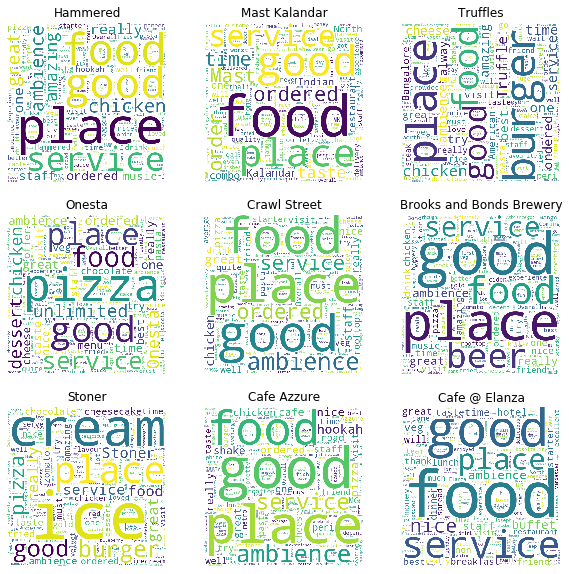

In [23]:
# Making wordcloud for ratings
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
rest = ratings['Restaurant'].value_counts()[:9]
#i=0
for r, subplot in zip(rest.index, ax.flatten()):

    #plt.figure(figsize=(10, 10))
    #plt.subplot(3, 3, i+1)
    
    # Getting all the ratings for different Restaurant
    corpus = ratings[ratings['Restaurant']==r]['Reviews'].values.tolist()
    
    # Getting all the ratings
    corpus = ' '.join(x for x in corpus)
    
    # Making a wordcloud
    wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=500, height=500).generate(corpus)

    plt.subplot(subplot)
    plt.imshow(wordcloud)
    plt.title(r)
    plt.axis('off')
plt.show()
    #i+=1

In [24]:
# Topic Modeling 

# Adding a new column which is 1 if ratings are positive and 0 if ratings are negative
ratings['sent'] = ratings['Ratings'].apply(lambda x: 1 if int(x)>2.5 else 0)


In [25]:
# For Positive Reviews
no_features = 10

data = ratings[ratings['sent']==1]['Reviews'][:3000]
# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english',\
                                ngram_range = (1, 2))
tf = tf_vectorizer.fit_transform(data)
tf_feature_names = tf_vectorizer.get_feature_names()

In [26]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

no_topics = 5

# Run NMF
#nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0)
lda_z = lda.fit_transform(tf)

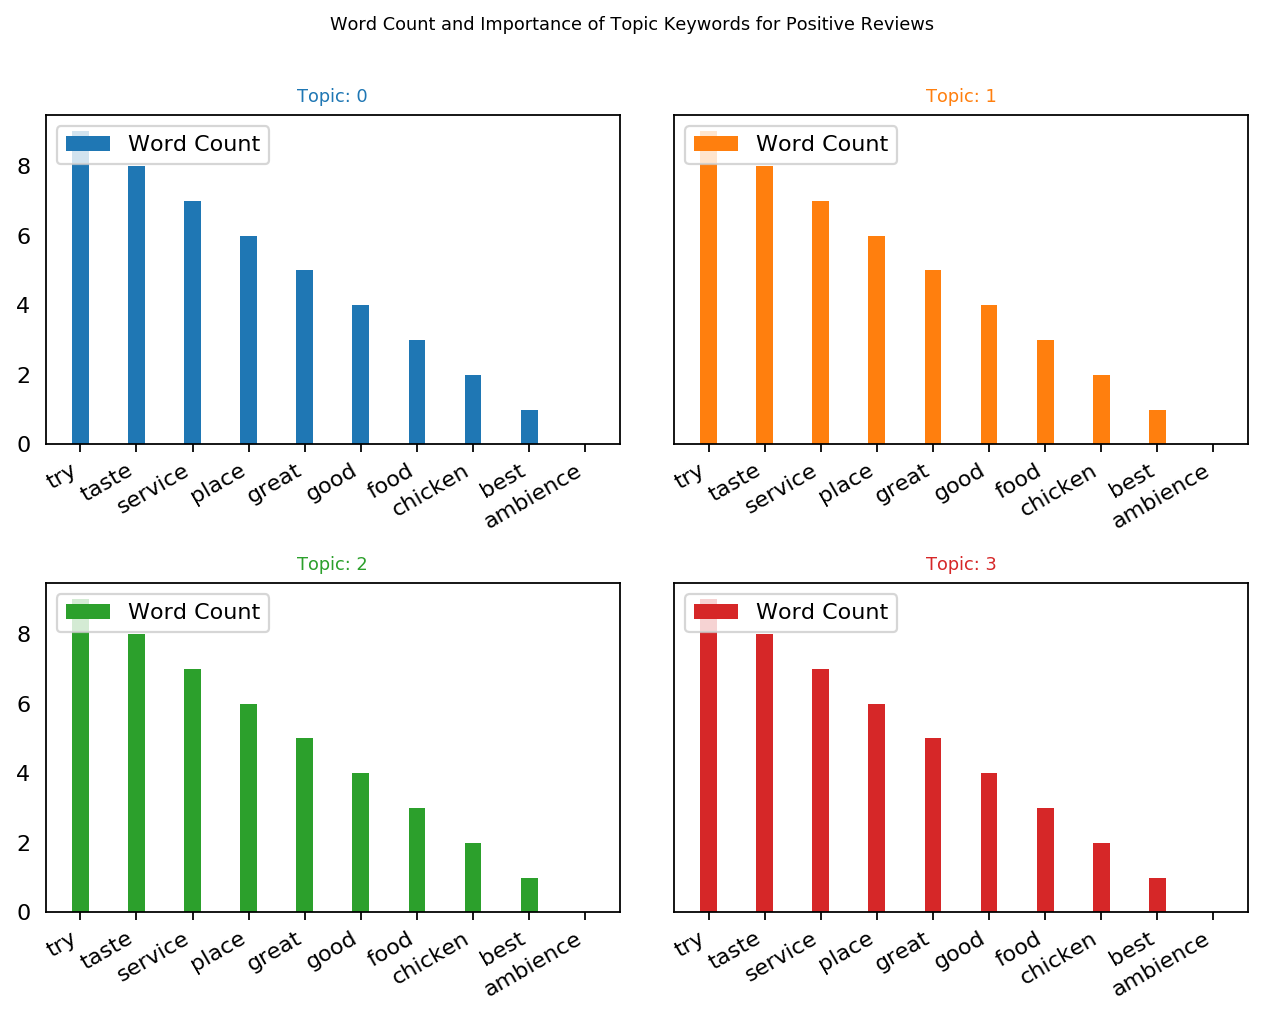

In [27]:
counter = Counter(corpus)
out = []
for topic_idx, topic in enumerate(lda.components_):
    for i in topic.argsort()[:-10 - 1:-1]:
        out.append([tf_feature_names[i], topic_idx, i, counter[tf_feature_names[i]]])


dataframe = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        
dataframe = dataframe.sort_values(by = ['importance'], ascending = False)

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(8,6), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="importance", data=dataframe.loc[dataframe.topic_id==i, :], color=cols[i], width=0.3, label='Word Count')
    #ax_twin = ax.twinx()
    #ax_twin.bar(x='word', height="importance", data=dataframe.loc[dataframe.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    #ax.set_ylabel('Word Count', color=cols[i])
    #ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=8)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(dataframe.loc[dataframe.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); 
    #ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords for Positive Reviews', fontsize=8, y=1.05)    
plt.show()

In [28]:
# For Negative Reviews
no_features = 1000

data = ratings[ratings['sent']==0]['Reviews'][:3000]
# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english',\
                                ngram_range = (1, 2))

tf = tf_vectorizer.fit_transform(data)
tf_feature_names = tf_vectorizer.get_feature_names()

In [29]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

no_topics = 5

# Run NMF
#nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0)
lda_z = lda.fit_transform(tf)

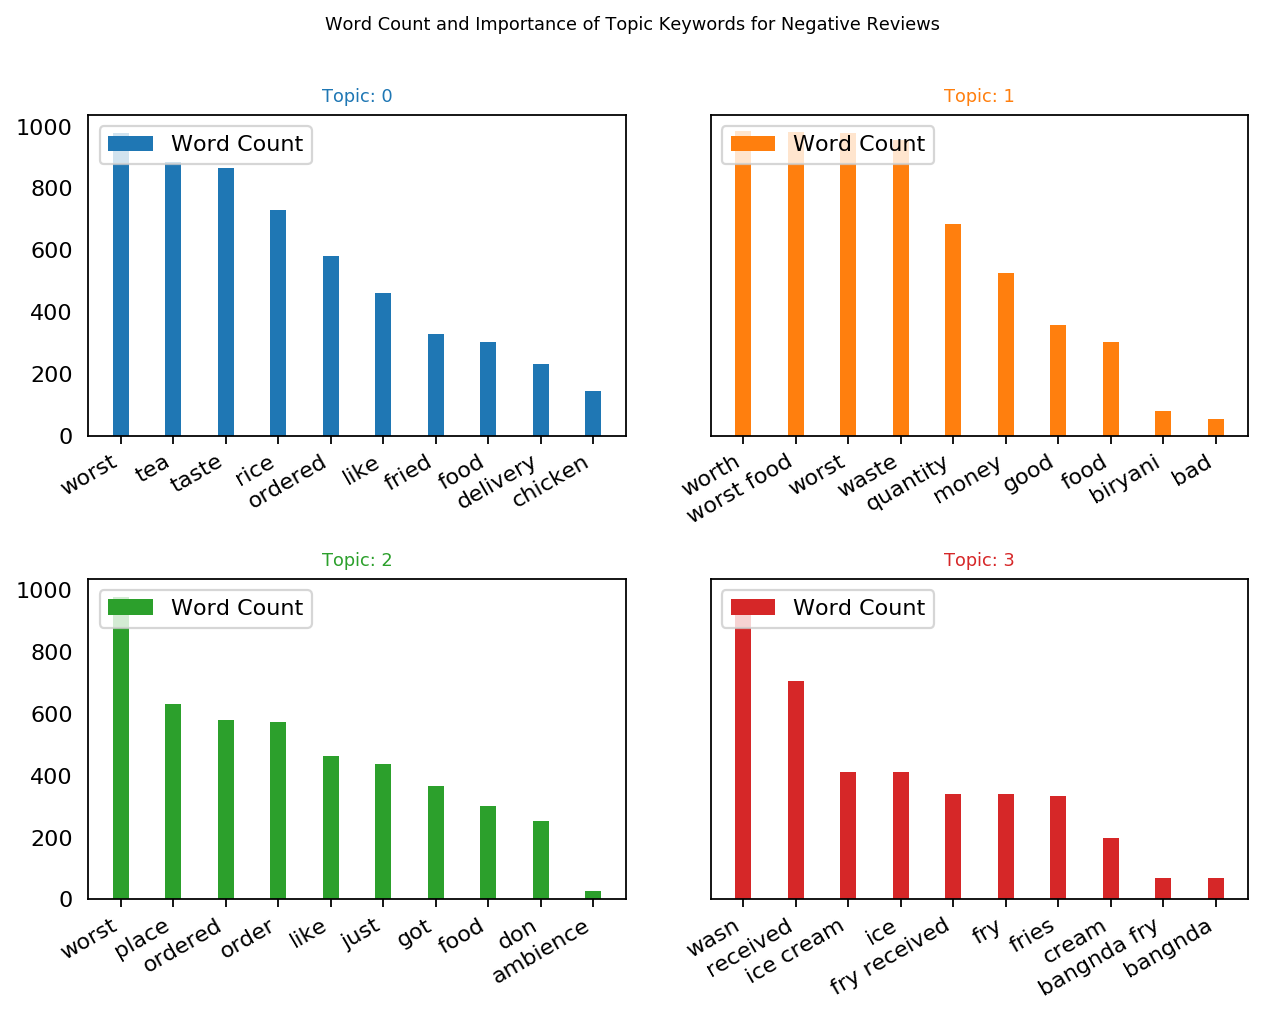

In [30]:
counter = Counter(corpus)
out = []
for topic_idx, topic in enumerate(lda.components_):
    for i in topic.argsort()[:-10 - 1:-1]:
        out.append([tf_feature_names[i], topic_idx, i, counter[tf_feature_names[i]]])


dataframe = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        
dataframe = dataframe.sort_values(by = ['importance'], ascending = False)
#print(dataframe)
# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(8,6), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="importance", data=dataframe.loc[dataframe.topic_id==i, :], color=cols[i], width=0.3, label='Word Count')
    #ax_twin = ax.twinx()
    #ax_twin.bar(x='word', height="importance", data=dataframe.loc[dataframe.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    #ax.set_ylabel('Word Count', color=cols[i])
    #ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=8)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(dataframe.loc[dataframe.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); 
    #ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords for Negative Reviews', fontsize=8, y=1.05)    
plt.show()

In [31]:
# Interesting thing to notice is that in both positive and negative reviews words such as chicken, taste and
# service appear, along with negative words such as bad, worse etc. This means that customer's review is strongly
# infuenced by small amount of words

In [32]:
# Sentiment Analysis
ratings['sent']=ratings['Ratings'].apply(lambda x: 1 if int(x)>3 else 0)
# Spliting into X and y variables
y = ratings['sent'].values
X = ratings['Reviews'].values

In [33]:
# Spliting the data into training and testing.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

# Analysing the data

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print(X_train[0])
print(y_train[0])
print(X_test[0])
print(y_test[0])

(791980,) (791980,) (527988,) (527988,)
This one is the most popular cafe arround Whitefield. The inside theme of the cafe is London. Liked the place , pretty cool for casual hangout.
Ordered pizza - 3 bird alferdo and in starters chicken slider .
It was very good.
1
Its been 2 hours since I ordered for home delivery, still not received it.
I was so hungry at 2:30 I placed the order now it is 4:46 an still no show.

THIS IS ABSOLUTELY PATHETIC SERVICE!!!!!!!

DONT LIKE IT!!
0


In [34]:
# Data Checking
# Check how many training examples in each category
# this is important to see whether the data set is balanced or skewed

training_labels = set(y_train)
print(training_labels)
training_category_dist = np.unique(y_train, return_counts = True)
print(training_category_dist)

{0, 1}
(array([0, 1]), array([291343, 500637]))


In [35]:
# There are almost 5 times more reviews as positive compared to negative reviews when 2.5 point was use
# therefore we used 3 to make the data much more balanced. Still number of positive reviews are greater. 

In [36]:
# Vectorization
# Bigram boolean vectorizer, set minimum document frequency to 2
bigram_bool_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english',\
                                ngram_range = (1, 2))

In [37]:
# Vectorizing the training data

# The vectorizer can do "fit" and "transform"
# fit is a process to collect unique tokens into the vocabulary
# transform is a process to convert each document to vector based on the vocabulary
# These two processes can be done together using fit_transform(), or used individually: fit() or transform()

# fit vocabulary in training documents and transform the training documents into vectors
X_train_vec = bigram_bool_vectorizer.fit_transform(X_train)

# check the content of a document vector
print(X_train_vec.shape)
#print(X_train_vec[0].toarray())


(791980, 978891)


In [38]:
# Vectorizing the testing data

# use the vocabulary constructed from the training data to vectorize the test data. 
# Therefore, use "transform" only, not "fit_transform", 
# otherwise "fit" would generate a new vocabulary from the test data

X_test_vec = bigram_bool_vectorizer.transform(X_test)

# print out #examples and #features in the test set
print(X_test_vec.shape)

(527988, 978891)


In [39]:
# Applying Multinomial Naive Bayes 

# initialize the MNB model
nb_clf= MultinomialNB()

# use the training data to train the MNB model
nb_clf.fit(X_train_vec,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [40]:
# Print Most informative and least informative features

# This is a function I found from stackexchange, and adapted a little bit
# The purpose is to print the top and bottom features nicely
# https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

# You can find many useful scripts from stackexchange or GitHub
# Most tasks are not so unique, so someone in this world might have done something similar and shared their code

def show_most_and_least_informative_features(vectorizer, clf, class_idx=0, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[class_idx], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[-n:])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [41]:
# Getting most and least informative words. 
show_most_and_least_informative_features(bigram_bool_vectorizer, nb_clf, class_idx=0, n=10)

	-17.1855	00 18          		-5.6077	ordered        
	-17.1855	00 50          		-5.5680	really         
	-17.1855	00 arrival     		-5.5580	try            
	-17.1855	00 check       		-5.3695	great          
	-17.1855	00 clock       		-5.3080	ambience       
	-17.1855	00 dat         		-5.2136	chicken        
	-17.1855	00 don         		-5.1977	service        
	-17.1855	00 drain       		-4.3092	food           
	-17.1855	00 evening     		-4.2667	good           
	-17.1855	00 everyday    		-4.2425	place          


In [58]:
# Predicting and getting accuracy
nb_clf.score(X_test_vec,y_test)

0.9560311976787351

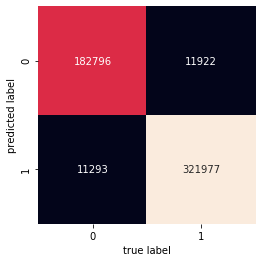

In [60]:
# print confusion matrix (row: ground truth; col: prediction)

from sklearn.metrics import confusion_matrix
y_pred = nb_clf.fit(X_train_vec, y_train).predict(X_test_vec)
mat = confusion_matrix(y_pred, y_test)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=[0,1], yticklabels=[0, 1])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [48]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94    194718
           1       0.96      0.97      0.97    333270

    accuracy                           0.96    527988
   macro avg       0.95      0.95      0.95    527988
weighted avg       0.96      0.96      0.96    527988



In [44]:
# As learned by topic modeling most important words while using sentiment analysis are ambience, chicken and service. 
# in addition to these words. Words such as place and food are also cosidered important. 

In [59]:
type(y_test)

numpy.ndarray